In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from ipywidgets import interact, widgets
import matplotlib.ticker as ticker
from collections import defaultdict

df = pd.read_csv(r"..\Problema2\log_centralizado.log", sep=";")



In [58]:
# Configuración para gráficos más estéticos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

df['t_ini'] = pd.to_datetime(df['t_ini'])
df['t_fin'] = pd.to_datetime(df['t_fin'])

df['fecha'] = df['t_ini'].dt.date 


df['duracion_ms'] = (df['t_fin'] - df['t_ini']).dt.total_seconds() * 1000

df['tamano_respuesta_kb'] = df['tamano_respuesta_bytes'].fillna(0) / 1024
#df['tamano_respuesta_mb'] = df['tamano_respuesta_bytes'].fillna(0) / (1024 * 1024)

df['hora'] = df['t_ini'].dt.hour
df['fecha'] = df['t_ini'].dt.date

# rangos etarios grafico1
bins = [0, 15, 30, 55, 100]
labels = ['0-14', '15-29', '30-54','55+']
df['rango_edad'] = pd.cut(df['edad'], bins=bins, labels=labels, right=False)

# 1. Gráfico de torta con porcentaje de consulta por rango etario

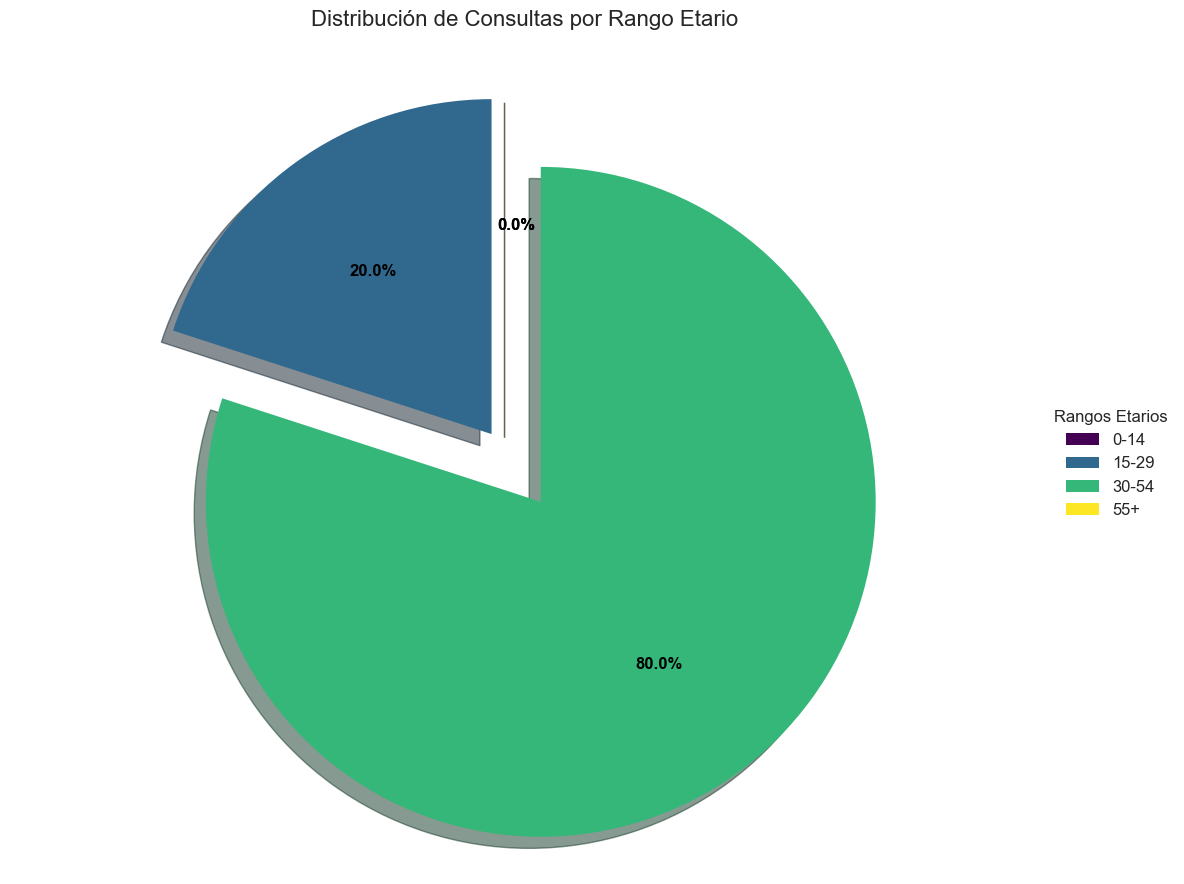

In [59]:
df_busquedas = df[df['operacion'] == 'busqueda en db']

plt.figure(figsize=(12, 9))

conteo_por_rango = df_busquedas['rango_edad'].value_counts().sort_index()
porcentajes = conteo_por_rango / conteo_por_rango.sum() * 100
    
colors = plt.cm.viridis(np.linspace(0, 1, len(porcentajes)))
explode = [0.1] * len(porcentajes)  
    

wedges, texts, autotexts = plt.pie(
    porcentajes, 
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    radius=0.8 
)
    

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')  
    autotext.set_fontweight('bold')  
    
    
plt.legend(
    wedges, 
    porcentajes.index,
    title="Rangos Etarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Consultas por Rango Etario', fontsize=16, pad=20)
plt.axis('equal')  # Para que el gráfico sea circular
plt.tight_layout()
plt.show()  

# 2. Curvas de promedios de score a través del tiempo con ventanas variables

In [60]:
df_ranking = df[(df['operacion'] == 'busqueda en db') & (~df['ranking'].isna())].copy()
df_ranking = df_ranking.sort_values('t_ini')


def graficar_ranking_por_fecha(fecha_sel):
    if not isinstance(fecha_sel, pd.Timestamp):
        fecha_sel = pd.to_datetime(fecha_sel)
    
    df_fecha = df_ranking[df_ranking['fecha'] == fecha_sel.date()]
    
    plt.figure(figsize=(12, 7), clear=True)
    
    if df_fecha.empty or len(df_fecha) < 2:
        plt.text(0.5, 0.5, 'No hay suficientes datos de ranking para esta fecha', 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
    else:
        plt.scatter(df_fecha['t_ini'], df_fecha['ranking'], alpha=0.5, 
                    color='gray', label='Valores individuales')
        ventanas = ['5s', '15s', '30s']
        colores = ['blue', 'red', 'green']
        
        for i, ventana in enumerate(ventanas):

            df_temp = df_fecha.copy().set_index('t_ini')
            promedio_tiempo = df_temp['ranking'].resample(ventana).mean().dropna()
            if not promedio_tiempo.empty:
                plt.plot(promedio_tiempo.index, promedio_tiempo.values, 
                         linewidth=2, color=colores[i], label=f'Ventana de {ventana}')
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gcf().autofmt_xdate() 
        
        plt.xlabel('Tiempo', fontsize=12)
        plt.ylabel('Score promedio', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.title(f'Evolución del Score Promedio - {fecha_sel.date()}', fontsize=16)
    plt.tight_layout()
    plt.show()


fechas_ranking_disponibles = sorted([pd.to_datetime(fecha) for fecha in df_ranking['fecha'].unique()])

output_ranking = widgets.Output()
dropdown_ranking = widgets.Dropdown(
    options=[(fecha.date().isoformat(), fecha) for fecha in fechas_ranking_disponibles],
    description='Fecha:',
    style={'description_width': 'initial'}
)


# Función callback específica para este gráfico
def on_change_ranking(change):
    with output_ranking:
        output_ranking.clear_output(wait=True)
        graficar_ranking_por_fecha(change.new)

# Conectar el callback a este dropdown específico
dropdown_ranking.observe(on_change_ranking, names='value')

# Mostrar los widgets de este gráfico específico
display(dropdown_ranking)
display(output_ranking)

# Mostrar el gráfico inicial si hay fechas disponibles
if fechas_ranking_disponibles:
    with output_ranking:
        graficar_ranking_por_fecha(fechas_ranking_disponibles[0])

Dropdown(description='Fecha:', options=(('2025-05-10', Timestamp('2025-05-10 00:00:00')), ('2025-05-11', Times…

Output()

# 3. Gráfico de cajas para tiempos promedio, min, max por esclavo (puerto)

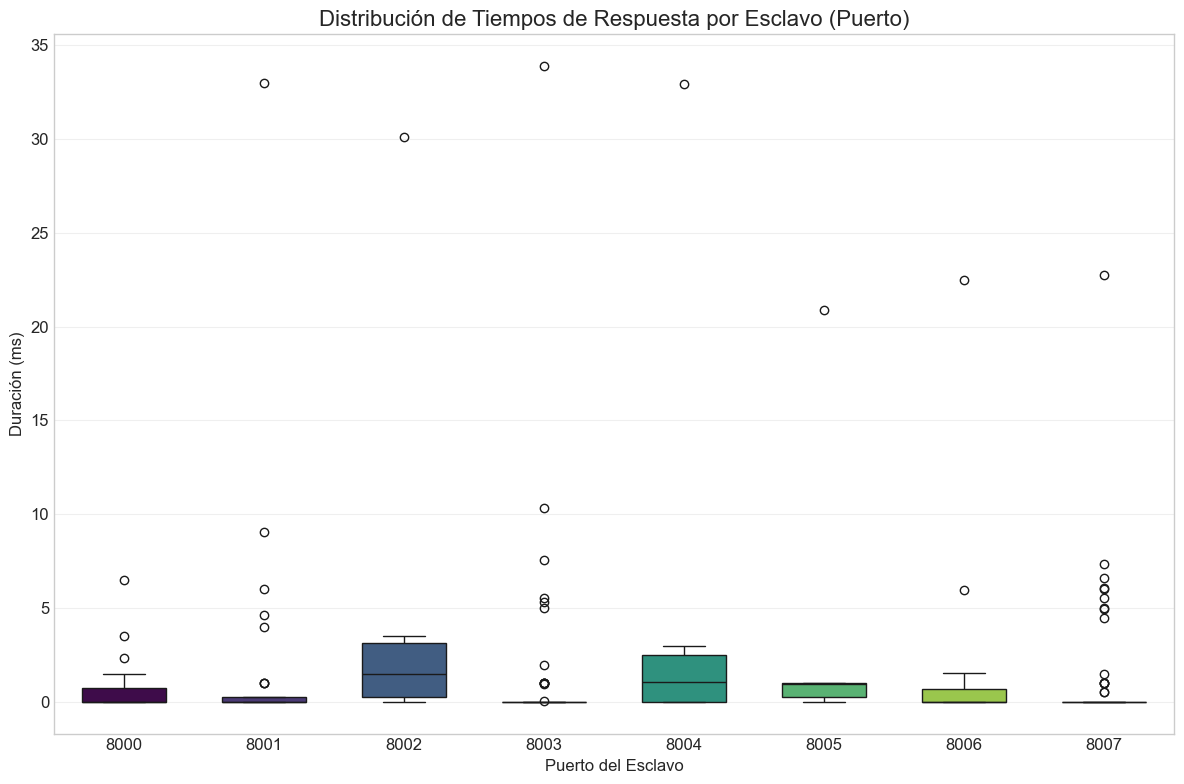

In [61]:
df_tiempos = df[df['operacion'].isin(['busqueda en db', 'mandar_resultados_a_master'])].copy()

plt.figure(figsize=(12, 8))

if len(df_tiempos) < 5:  
    plt.text(0.5, 0.5, 'No hay suficientes datos de tiempos para analizar', 
             ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    sns.boxplot(x='puerto_maquina', y='duracion_ms', hue='puerto_maquina', 
                data=df_tiempos, palette='viridis', width=0.6, legend=False)
    
    plt.xlabel('Puerto del Esclavo', fontsize=12)
    plt.ylabel('Duración (ms)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    
    for puerto in df_tiempos['puerto_maquina'].unique():
        tiempos = df_tiempos[df_tiempos['puerto_maquina'] == puerto]['duracion_ms']
        if not tiempos.empty:
            y_pos = tiempos.max() + (tiempos.max() * 0.05)
            plt.annotate(f'Min: {tiempos.min():.2f}\nMax: {tiempos.max():.2f}\nPromedio: {tiempos.mean():.2f}', 
                         xy=(puerto, y_pos),
                         ha='center', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.title('Distribución de Tiempos de Respuesta por Esclavo (Puerto)', fontsize=16)
plt.tight_layout()
plt.show()

# 4. Latencia de red entre maestro y esclavos

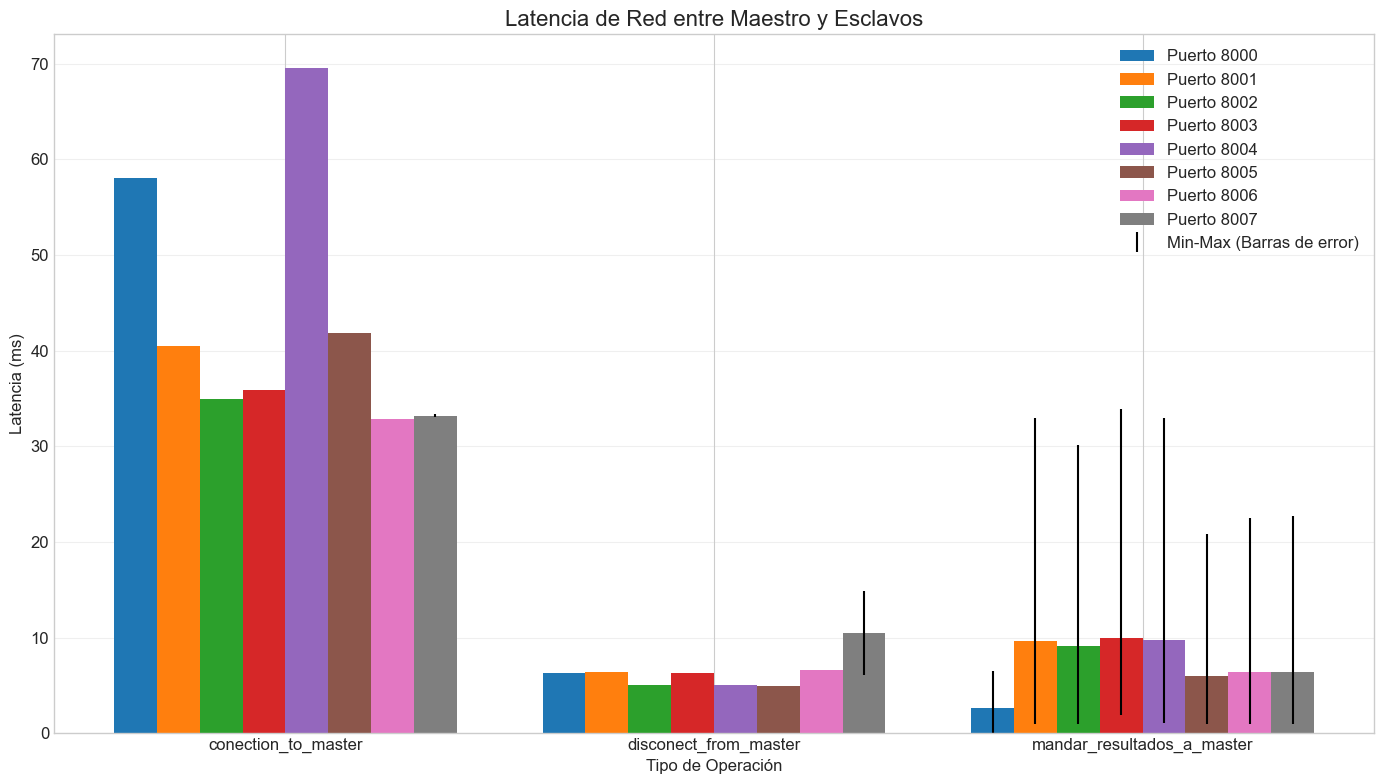

In [62]:
df_red = df[df['operacion'].isin([
    'conection_to_master', 
    'mandar_resultados_a_master', 
    'disconect_from_master'
])].copy()

plt.figure(figsize=(14, 8))

if len(df_red) < 3:  
    plt.text(0.5, 0.5, 'No hay suficientes datos de latencia para analizar', 
             ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    df_latencia = df_red.groupby(['operacion', 'puerto_maquina'])['duracion_ms'] \
                        .agg(['mean', 'min', 'max']).reset_index()

    operaciones = ['conection_to_master', 'disconect_from_master', 'mandar_resultados_a_master']
    puertos = sorted(df_latencia['puerto_maquina'].unique())

    all_combinations = pd.MultiIndex.from_product([operaciones, puertos], 
                                                   names=['operacion', 'puerto_maquina'])
    
    df_latencia_full = df_latencia.set_index(['operacion', 'puerto_maquina']) \
                                  .reindex(all_combinations).reset_index()

    n_operaciones = len(operaciones)
    n_puertos = len(puertos)
    
    r = np.arange(n_operaciones)
    bar_width = 0.1  # más pequeño para que quepan todos los puertos

    for i, puerto in enumerate(puertos):
        df_p = df_latencia_full[df_latencia_full['puerto_maquina'] == puerto]
        
        means = df_p['mean'].values
        mins = df_p['min'].values
        maxs = df_p['max'].values

        positions = r + i * bar_width

        # Calcular barras de error
        yerr = np.array([
            means - mins, 
            maxs - means
        ])
        # Reemplazar NaNs con ceros para evitar errores
        yerr = np.nan_to_num(yerr)
        means = np.nan_to_num(means)

        plt.bar(positions, means, width=bar_width, label=f'Puerto {puerto}', yerr=yerr)

    plt.xticks(r + bar_width * (n_puertos - 1) / 2, operaciones)
    
    plt.xlabel('Tipo de Operación', fontsize=12)
    plt.ylabel('Latencia (ms)', fontsize=12)
    plt.title('Latencia de Red entre Maestro y Esclavos', fontsize=16)

    handles, labels = plt.gca().get_legend_handles_labels()
    error_bar = Line2D([0], [0], color='black', linewidth=2, linestyle='none', 
                       marker='|', markersize=15, markeredgewidth=1.5, label='Min-Max (Barras de error)')
    handles.append(error_bar)
    plt.legend(handles=handles)

    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Tamaño en MB de las respuestas por hora a través del día

In [63]:
# Filtrar solo respuestas
df_respuestas = df[df['operacion'] == 'mandar_resultados_a_master'].copy()

fechas_disponibles = sorted(df_respuestas['fecha'].unique())


# Función de gráfico con eje X como tiempo detallado y agrupación de etiquetas
def graficar_por_fecha(fecha_sel):
    plt.figure(figsize=(14, 8), dpi=120)  # Aumentado DPI para mejor resolución
    df_fecha = df_respuestas[df_respuestas['fecha'] == fecha_sel]

    if df_fecha.empty:
        plt.text(0.5, 0.5, 'No hay datos para esta fecha seleccionada', 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        return
        
    df_fecha = df_fecha.sort_values('t_ini')

    # Calcular límites Y específicos para esta fecha
    ymin_fecha = 0
    ymax_fecha = df_fecha['tamano_respuesta_kb'].max() * 1.2  # 20% de margen

    # Graficar puntos individuales con t_ini como eje X
    plt.plot(df_fecha['t_ini'], df_fecha['tamano_respuesta_kb'], 'o-', 
             linewidth=2, markersize=8, color='#1f77b4', 
             label=f'Fecha: {fecha_sel}')

    # Formato de fecha con horas, minutos, segundos
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate()

    # Mejorar la apariencia del gráfico
    plt.xlabel('Hora', fontsize=12, fontweight='bold')
    plt.ylabel('Tamaño de respuesta (KB)', fontsize=12, fontweight='bold')
    plt.ylim(ymin_fecha, ymax_fecha)
    plt.grid(True, alpha=0.3)

    # Función para calcular distancia personalizada entre puntos
    def distancia_puntos(punto1, punto2, peso_tiempo=0.7, peso_valor=0.3):
        # Calcular la diferencia en segundos entre los tiempos
        diff_tiempo = abs((punto1[0] - punto2[0]).total_seconds())
        # Normalizar por un factor de tiempo (ej: 60 segundos como máximo considerado)
        max_tiempo_diff = 60  # Ajustar según tus datos
        norm_diff_tiempo = min(diff_tiempo / max_tiempo_diff, 1.0)
        
        # Calcular la diferencia entre los valores
        diff_valor = abs(punto1[1] - punto2[1])
        # Normalizar por un factor de valor (10% del rango)
        max_valor = df_fecha['tamano_respuesta_kb'].max()
        norm_diff_valor = min(diff_valor / (max_valor * 0.1), 1.0) if max_valor > 0 else 0
        
        # Combinar las diferencias con sus respectivos pesos
        return peso_tiempo * norm_diff_tiempo + peso_valor * norm_diff_valor
    
    # Crear estructura para agrupar puntos
    df_fecha = df_fecha.copy()
    puntos = [(row['t_ini'], row['tamano_respuesta_kb'], i) 
              for i, (_, row) in enumerate(df_fecha.iterrows())]
    
    # Definir umbral para considerar puntos cercanos (ajustar según necesidad)
    umbral_cercania = 0.3
    
    # Inicializar clusters
    clusters = []
    puntos_visitados = set()
    
    # Asignar cada punto a un cluster
    for i, punto in enumerate(puntos):
        if i in puntos_visitados:
            continue
            
        # Crear nuevo cluster
        cluster_actual = [i]
        puntos_visitados.add(i)
        
        # Buscar puntos cercanos recursivamente
        j = 0
        while j < len(cluster_actual):
            punto_idx = cluster_actual[j]
            
            # Buscar puntos cercanos no visitados
            for k, otro_punto in enumerate(puntos):
                if k not in puntos_visitados:
                    dist = distancia_puntos(puntos[punto_idx][:2], otro_punto[:2])
                    if dist < umbral_cercania:
                        cluster_actual.append(k)
                        puntos_visitados.add(k)
            
            j += 1
        
        clusters.append(cluster_actual)
    
    # Asignar cada punto a su cluster
    df_fecha['cluster'] = -1
    for i, cluster in enumerate(clusters):
        for punto_idx in cluster:
            df_fecha.iloc[puntos[punto_idx][2], df_fecha.columns.get_loc('cluster')] = i
    
    # Agrupar resultados por cluster
    cluster_info = {}
    for cluster_id in df_fecha['cluster'].unique():
        cluster_points = df_fecha[df_fecha['cluster'] == cluster_id]
        
        # Calcular posición promedio para la etiqueta
        avg_time = cluster_points['t_ini'].mean()
        avg_size = cluster_points['tamano_respuesta_kb'].mean()
        
        # Sumar todas las respuestas en este cluster
        total_resp = cluster_points['cant_resultados'].sum()
        count_points = len(cluster_points)
        
        cluster_info[cluster_id] = {
            'time': avg_time,
            'size': avg_size,
            'total_resp': total_resp,
            'count': count_points
        }
    
    # Crear mapa de posiciones ocupadas para evitar superposición
    posiciones_ocupadas = {}
    
    # Ordenar clusters por tiempo para procesar primero los más antiguos
    sorted_clusters = sorted(cluster_info.items(), key=lambda x: x[1]['time'])
    
    # Agregar etiquetas para cada cluster
    for cluster_id, info in sorted_clusters:
        # Crear texto más informativo si hay múltiples puntos agrupados
        if info['count'] > 1:
            texto = f"{int(info['total_resp'])} resp. ({info['count']} datos)"
        else:
            texto = f"{int(info['total_resp'])} resp."
        
        # Posición inicial para la etiqueta
        x_pos = info['time']
        y_pos = info['size']
        
        # Verificar si la posición está ocupada y ajustar verticalmente si es necesario
        offset_y = 10  # offset inicial
        while (x_pos, y_pos + offset_y) in posiciones_ocupadas:
            offset_y += 20  # incrementar offset hasta encontrar espacio libre
        
        # Marcar esta posición como ocupada
        posiciones_ocupadas[(x_pos, y_pos + offset_y)] = True
        
        # Posicionar etiqueta con el offset calculado
        plt.annotate(texto, 
                    (x_pos, y_pos),
                    textcoords="offset points", 
                    xytext=(0, offset_y), 
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0", 
                                   color='gray', alpha=0.7))

    plt.legend(loc='upper left')
    plt.title('Tamaño de Respuestas con Hora Detallada', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Dropdown interactivo
output = widgets.Output()
dropdown = widgets.Dropdown(options=fechas_disponibles, description='Fecha:')

def on_change(change):
    with output:
        output.clear_output()
        graficar_por_fecha(change.new)

dropdown.observe(on_change, names='value')

# Mostrar el dropdown y la primera visualización
display(dropdown)
display(output)

# Mostrar el gráfico inicial si hay fechas disponibles
if fechas_disponibles:
    with output:
        graficar_por_fecha(fechas_disponibles[0])

Dropdown(description='Fecha:', options=(datetime.date(2025, 5, 10), datetime.date(2025, 5, 11)), value=datetim…

Output()